# Setup


In [ ]:
!pip uninstall fastai -y --quiet
!pip install fastai --quiet

     |████████████████████████████████| 197 kB 5.0 MB/s 
     |████████████████████████████████| 60 kB 3.2 MB/s 


In [ ]:
from fastai.vision.all import *
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

set_seed(42)
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/UC3M/CUARTO/TFG')

Mounted at /content/drive


# Data

In [ ]:
def filter(path):
    black = []
    white = []
    
    for image in get_image_files(path):
        if   'black' in image.__str__(): black.append(np.array(Image.open(image).crop((0, 0, 181, 181))))
        elif 'white' in image.__str__(): white.append(np.array(Image.open(image).crop((0, 0, 181, 181))))
    return black, white

In [ ]:
train_images_black, train_images_white = filter(path/'data'/'train')
valid_images_black, valid_images_white = filter(path/'data'/'valid')

img_shape = train_images_black[0].shape

In [ ]:
def generate_mask(shape):
  mask = np.ones(shape)
  width = shape[0]
  heigth = shape[1]
  channels = shape[2]

  for i in range(width):
    x = i / width * 2 - 1
    for j in range(heigth):
      y = j / heigth * 2 - 1
      value = sigmoid(max(abs(x), abs(y)))
      for k in range(channels): mask[i][j][k] -= value
  return mask

def sigmoid(value):
  a = 10
  b = 0.2
  c = math.pow(value, a)
  return  c / (c + math.pow(b - b * value, a))

def apply_mask(img):
  return np.multiply(mask, img)

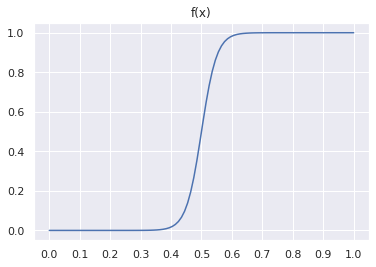

In [ ]:
x = np.linspace(0,1,100)
axis = np.arange(11)/10
sigmoid_v = np.vectorize(sigmoid)
y = sigmoid_v(x)

plt.figure()
plt.plot(x, y)
plt.xticks(axis)
plt.title('f(x)')
plt.show()

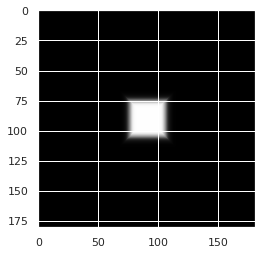

In [ ]:
mask = generate_mask(img_shape)
plt.imshow(mask)

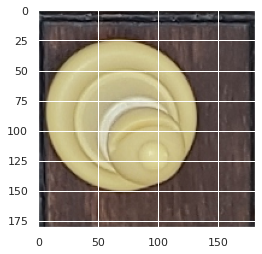

In [ ]:
image = train_images_white[0]
plt.imshow(image)

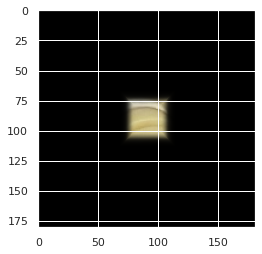

In [ ]:
plt.imshow(apply_mask(image)/255)

# KMeans

In [ ]:
def plot(df_black: pd.DataFrame, df_white: pd.DataFrame, dataset: str) -> None:
    accuracy = (len(df_white[df_white['cluster']==1]) + len(df_black[df_black['cluster']==0]))/(len(df_white)+len(df_black))

    plt.figure()

    plt.scatter(df_black[df_black['cluster']==0]['mean'], [0]*len(df_black[df_black['cluster']==0]), color='black', label='Black')
    plt.scatter(df_black[df_black['cluster']==1]['mean'], [0]*len(df_black[df_black['cluster']==1]), color='yellow', label='Missclassified')
    plt.scatter(df_black['mean'].to_numpy().mean(), [0], color='green', label='Mean')
    plt.scatter(black_cluster, 0, color='red', label='Centroid')

    plt.scatter(df_white[df_white['cluster']==0]['mean'], [1]*len(df_white[df_white['cluster']==0]), color='yellow')
    plt.scatter(df_white[df_white['cluster']==1]['mean'], [1]*len(df_white[df_white['cluster']==1]), color='blue', label='White')
    plt.scatter(df_white['mean'].to_numpy().mean(), [1], color='green')
    plt.scatter(white_cluster, 1, color='red')


    plt.scatter(10, accuracy, label='Accuracy',)

    plt.title(f'Color classification using KMeans: {dataset}')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
train_black = [apply_mask(img).mean() for img in train_images_black]
train_white = [apply_mask(img).mean() for img in train_images_white]
train = np.array(train_black + train_white)

df_train_black = pd.DataFrame({
    'color': [0] * len(train_black),
    'mean': train_black
})

df_train_white = pd.DataFrame({
    'color': [1] * len(train_white),
    'mean': train_white
})

In [ ]:
valid_black = [apply_mask(img).mean() for img in valid_images_black]
valid_white = [apply_mask(img).mean() for img in valid_images_white]
valid = np.array(valid_black + valid_white)

df_valid_black = pd.DataFrame({
    'color': [0] * len(valid_black),
    'mean': valid_black
})

df_valid_white = pd.DataFrame({
    'color': [1] * len(valid_white),
    'mean': valid_white
})

In [ ]:
km = KMeans(n_clusters=2, init= np.array([[0], [255]]), max_iter=1000)
km.fit(train.reshape(-1,1))

black_cluster = km.cluster_centers_[0][0]
white_cluster = km.cluster_centers_[1][0]
black_cluster, white_cluster

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


(15.003032966423222, 38.008426474233374)

In [ ]:
df_train_black['cluster'] = km.predict(df_train_black['mean'].to_numpy().reshape(-1,1))
df_train_white['cluster'] = km.predict(df_train_white['mean'].to_numpy().reshape(-1,1))

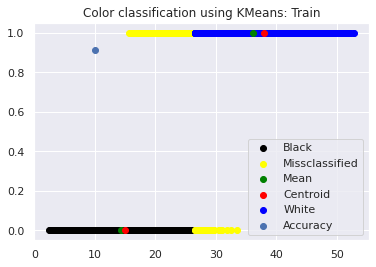

In [ ]:
plot(df_train_black, df_train_white, 'Train')

In [ ]:
df_valid_black['cluster'] = km.predict(df_valid_black['mean'].to_numpy().reshape(-1,1))
df_valid_white['cluster'] = km.predict(df_valid_white['mean'].to_numpy().reshape(-1,1))

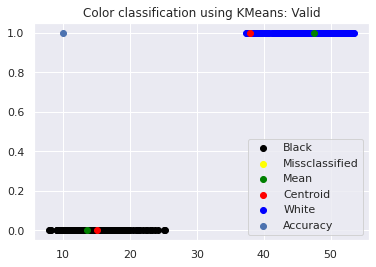

In [ ]:
plot(df_valid_black, df_valid_white, 'Valid')

In [ ]:
km.fit(valid.reshape(-1,1))

black_cluster = km.cluster_centers_[0][0]
white_cluster = km.cluster_centers_[1][0]
black_cluster, white_cluster

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


(13.577669546480088, 47.4866501529323)

In [ ]:
df_valid_black['cluster'] = km.predict(df_valid_black['mean'].to_numpy().reshape(-1,1))
df_valid_white['cluster'] = km.predict(df_valid_white['mean'].to_numpy().reshape(-1,1))

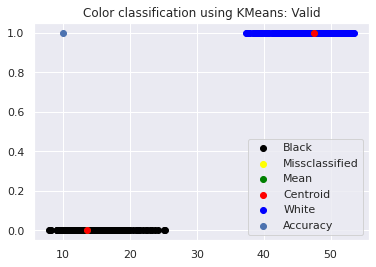

In [ ]:
plot(df_valid_black, df_valid_white, 'Valid')